# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

(Inspired by "A Tutorial on Vanilla Bayesian Optimization" by Darian Nwankwo)

In [21]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions
using Optim

In [1]:
include("../src/testfns.jl")
include("../src/surrogates.jl")
include("../src/acquisitions.jl")

LoadError: LoadError: ArgumentError: Package ForwardDiff not found in current path.
- Run `import Pkg; Pkg.add("ForwardDiff")` to install the ForwardDiff package.
in expression starting at /Users/ethanhersch/BO_Research/Multi-Fidelity-Bayesian-Optimization/src/kernels.jl:4
in expression starting at /Users/ethanhersch/BO_Research/Multi-Fidelity-Bayesian-Optimization/src/surrogates.jl:3

In [23]:
include("../src/kernels.jl")

get_random_kernel (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed. Put these obervations into an nxd matrix X.

Test Function: GramacyLee


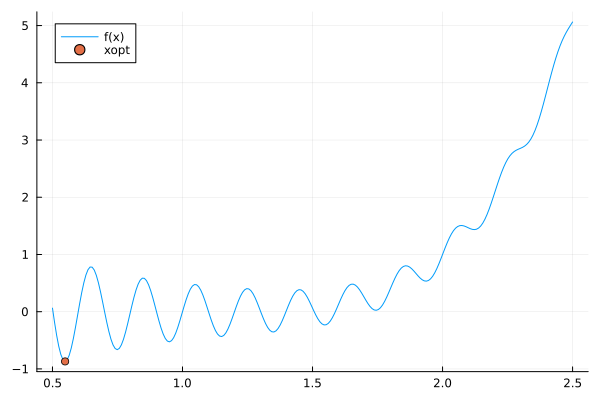

In [40]:
testfn, testfn_name, X, y =  get_toy_problem(N=100, fn_name = "GramacyLee")
println("Test Function: $(testfn_name)")
tplot(testfn)

## 2. Initialize surrogate model

Gather information regarding predictive mean and variance for our function. I will use kernels defined in kernels.jl.

In [41]:
#this will be changed so don't always
ψ = SquaredExponential(1.)

Kernel([1.0], var"#squared_exponential#269"{Float64}(1.0))

In [43]:
sur = ZeroMeanGP(ψ, X, y, noise = 1e-6)

ZeroMeanGaussianProcess(Kernel([1.0], var"#squared_exponential#269"{Float64}(1.0)), [2.450002276915351 0.578514860682585 … 2.3559583711182808 0.622873308265461], [1.000001 0.17355988605671538 … 0.9955876351030282 0.18839769829359318; 0.17355988605671538 1.000001 … 0.2060466424018757 0.9990166478719176; … ; 0.9955876351030282 0.2060466424018757 … 1.000001 0.22273068731843637; 0.18839769829359318 0.9990166478719176 … 0.22273068731843637 1.000001], [1.000000499999875 0.0 … 0.0 0.0; 0.17355979927683743 0.9848238401231887 … 0.0 0.0; … ; 0.9955871373095839 0.03376516421826633 … 0.0010483849620217748 0.0; 0.18839760409481468 0.9812093880669162 … -1.4226667152879323e-6 0.0010512599352913753], [3.802325809438652, -1.3308012562396325, -1.3395511020935857, -0.7567208750089848, -1.13398591911548, -0.12265853013339834, 1.8810518484414112, -0.2153141537099722, -0.7928242992701033, -0.05452596311072466  …  -0.41031293371666067, -0.597611563931851, -1.0549407110372075, 1.4138827491467185, -1.169913265

In [ ]:
plot()